# Тестовое задание в команду продуктовой аналитики, Gett.

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину). 

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('https://github.com/slgero/testovoe/raw/master/Gett/data/data_orders.csv')
offers = pd.read_csv('https://github.com/slgero/testovoe/raw/master/Gett/data/data_offers.csv')

# Анализ данных

In [20]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


**1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [21]:
df.order_status_key.value_counts()

4    7307
9    3409
Name: order_status_key, dtype: int64

In [22]:
df.order_status_key.value_counts(normalize=True)

4    0.681878
9    0.318122
Name: order_status_key, dtype: float64

In [23]:
df.isna().mean()

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

In [24]:
len(df.order_gk.value_counts()) == len(df) #все заказы уникальны

True

In [25]:
plot = df.groupby(['is_driver_assigned_key', 'order_status_key'])['order_gk'].count().reset_index()

In [26]:
plot

,is_driver_assigned_key,order_status_key,order_gk
0,0,4,4496
1,0,9,3406
2,1,4,2811
3,1,9,3


In [27]:
df[df['is_driver_assigned_key']==0]['order_status_key'].value_counts(normalize=True)

4    0.56897
9    0.43103
Name: order_status_key, dtype: float64

In [28]:
df[df['is_driver_assigned_key']==1]['order_status_key'].value_counts(normalize=True)

4    0.998934
9    0.001066
Name: order_status_key, dtype: float64

In [29]:
df['is_canceled_by_customer'] = (df['order_status_key'] == 4)*1

Text(0.5, 0, 'Категория')

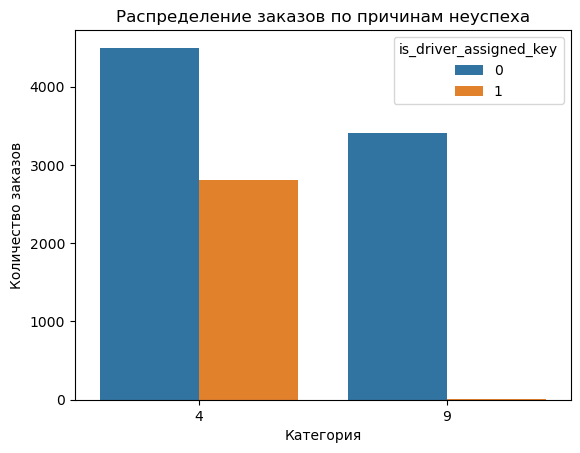

In [30]:

ax = sns.barplot(data=plot, x='order_status_key', y='order_gk', hue='is_driver_assigned_key')
ax.set_title('Распределение заказов по причинам неуспеха')
ax.set_ylabel('Количество заказов')
ax.set_xlabel('Категория')

**2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

In [31]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_canceled_by_customer
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0


In [32]:
df['hour'] = df['order_datetime'].str[:2]

In [33]:
client = df[df['order_status_key']==4].groupby('hour')['is_canceled_by_customer'].agg(['count'])

In [34]:
reject = df[df['order_status_key']==9].groupby('hour')['is_canceled_by_customer'].agg(['count'])

TypeError: Got both 'c' and 'color', which are aliases of one another

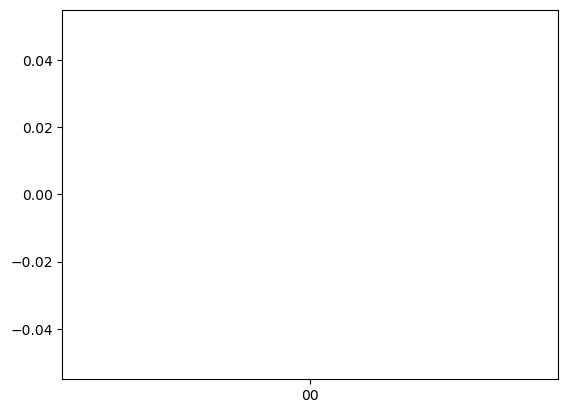

In [35]:
a = sns.lineplot(data=reject, x='hour', y = 'count', c = 'red')
b = sns.lineplot(data=client, x='hour', y = 'count', c = 'green')
a.set_xlabel('Часы')
a.set_ylabel('Количество заказов')

В 8 часов утра наблюдается резкий пик по отказам в обеих категориях

**3**. Постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

In [36]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_canceled_by_customer,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0,21


In [37]:
df.groupby('is_driver_assigned_key')['cancellations_time_in_seconds'].agg(['mean', 'median', 'count'])

,mean,median,count
is_driver_assigned_key,,,
0,110.371441,88.0,4496
1,233.897901,127.0,2811


In [38]:
with_driver = df[df['is_driver_assigned_key']==1].groupby('hour')['cancellations_time_in_seconds'].agg(['mean', 'median'])
without_driver = df[df['is_driver_assigned_key']==0].groupby('hour')['cancellations_time_in_seconds'].agg(['mean', 'median'])

<AxesSubplot:xlabel='hour'>

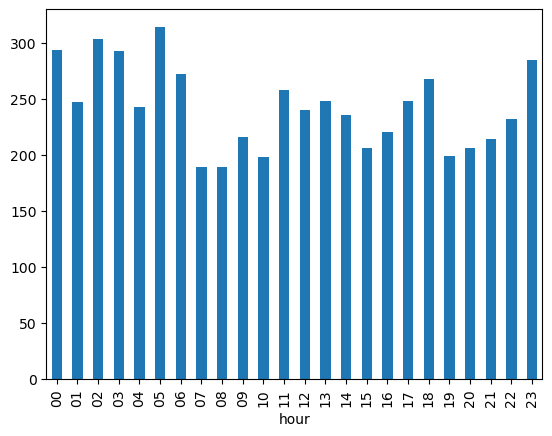

In [39]:
with_driver['mean'].plot(kind='bar')
#среднее время до отмены с водителем

<AxesSubplot:xlabel='hour'>

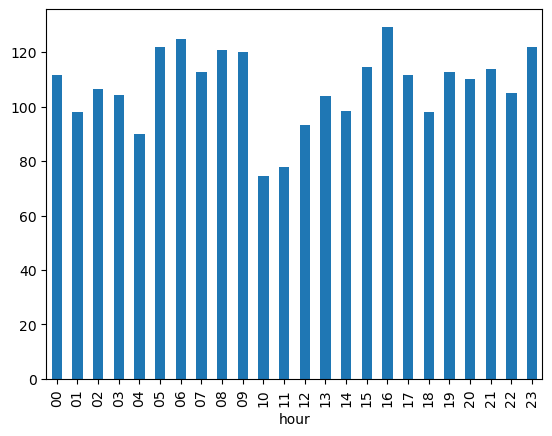

In [40]:
without_driver['mean'].plot(kind='bar')
#среднее время до отмены без водителем

In [41]:
without_d = without_driver['mean'].mean()
with_d = with_driver['mean'].mean()
print(f'Среднее время отмены если водителя назначили: {with_d}', f'Среднее время отмены если водителя не назначили: {without_d}', sep = '\n')

Среднее время отмены если водителя назначили: 242.6063235304107
Среднее время отмены если водителя не назначили: 107.31176564166903


Если водитель не назначен, то время отмены меньше

По часам время до отмены распределено практически равномерно

**4.** Постройте распределение среднего ЕТА по часам. Чем можно объяснить такой вид графика?

In [42]:
df.head()


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_canceled_by_customer,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0,21


<AxesSubplot:>

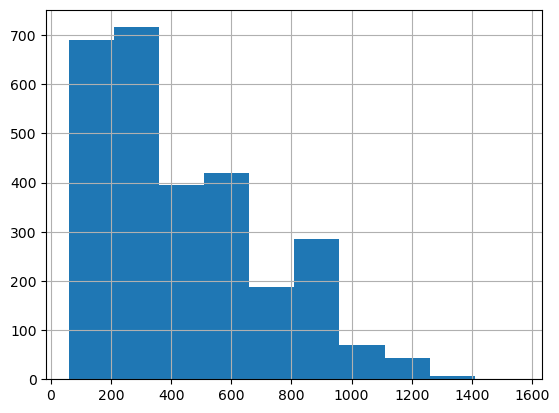

In [43]:
df.m_order_eta.hist()

In [44]:
df.m_order_eta.isna().mean()

0.7374020156774916

In [45]:
ETA = df.groupby('hour')['m_order_eta'].agg(['mean', 'count', 'median']).reset_index()

Text(0.5, 0, 'Часы')

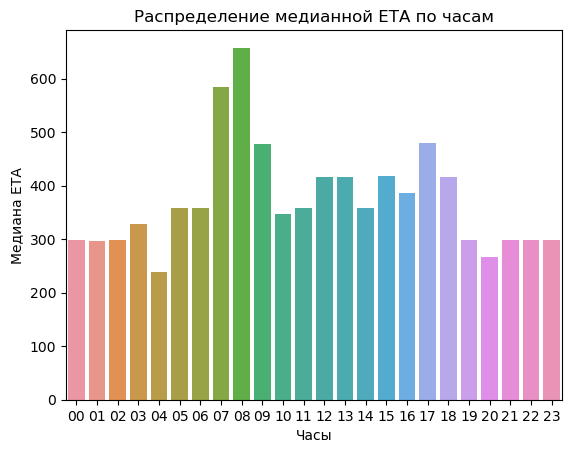

In [46]:
d = sns.barplot(data=ETA, x='hour', y='median')
d.set_title('Распределение медианной ЕТА по часам')
d.set_ylabel('Медиана ЕТА')
d.set_xlabel('Часы')

Text(0.5, 0, 'Часы')

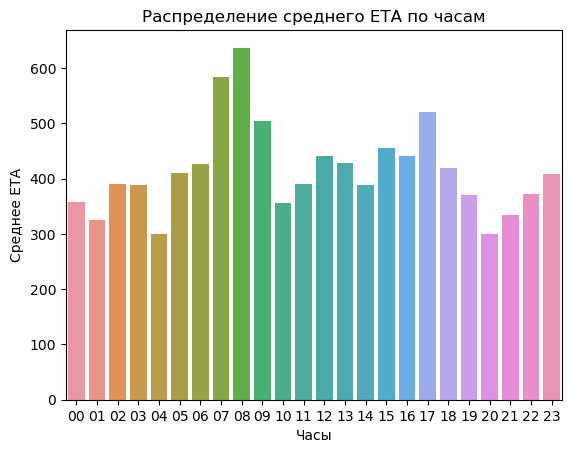

In [47]:
e = sns.barplot(data=ETA, x='hour', y='mean')
e.set_title('Распределение среднего ЕТА по часам')
e.set_ylabel('Среднее ЕТА')
e.set_xlabel('Часы')


Время до прибытия машины значительно выше в утренние часы пик

5. Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [48]:
offers_by_order = offers.groupby('order_gk')['offer_id'].nunique().reset_index()

In [49]:
df = df.merge(offers_by_order, how='left', on='order_gk')

In [50]:
df['offer_id'] = df['offer_id'].fillna(0)

<AxesSubplot:>

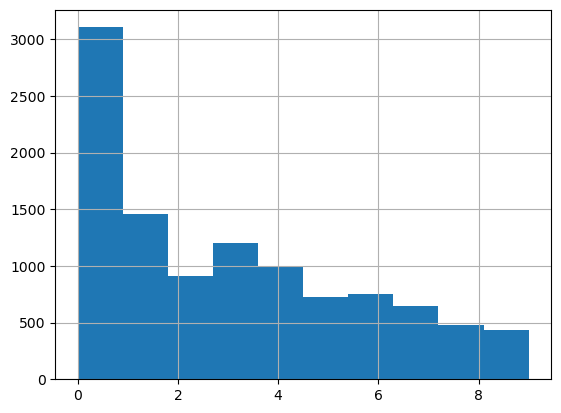

In [51]:
df['offer_id'].hist()

In [52]:
df.groupby('hour')['offer_id'].agg(['mean', 'count', 'median']).head()

,mean,count,median
hour,,,
00,2.918009,683,2.0
01,2.770701,471,2.0
02,2.657658,555,2.0
03,2.764133,513,2.0
04,1.493421,152,1.0


Text(0, 0.5, 'Среднее число увиденных заказов')

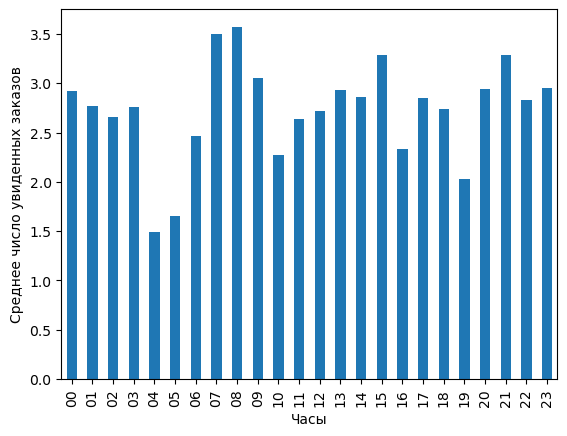

In [53]:
f = df.groupby('hour')['offer_id'].agg(['mean', 'count', 'median'])['mean'].plot(kind='bar')
f.set_xlabel('Часы')
f.set_ylabel('Среднее число увиденных заказов')

In [54]:
df['offer_id'].mean()
#Распределение водителей увидевших заказ, практически равномерное
#исключения - 4 и 5 часы утра, просадка почти в 2 раза, но это и самое метрвое время по колличесту заказов

2.917879805897723

**6*.** Гексаконы.
Воспользовавшись пакетами h3 и folium, посчитайте, сколько гексагонов размера 8 (https://uber.github.io/h3/#/documentation/core-library/resolution-table) содержат 80% всех заказов из исходного датасета и визуализируйте гексагон с наибольшим количеством фейлов на карте.

In [55]:
! pip install h3

     -------------------------------------- 855.6/855.6 kB 1.6 MB/s eta 0:00:00


In [56]:
>>> import h3
>>> lat, lng = 37.769377, -122.388903
>>> resolution = 9
>>> h3.geo_to_h3(lat, lng, resolution)


'89283082e73ffff'

In [57]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_canceled_by_customer,hour,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1,18,1.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1,20,3.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1,12,6.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1,13,3.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0,21,0.0


In [58]:
def get_gexagon(row):
  resolution = 8
  return h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], resolution)


In [59]:
df['gexagon'] = df.apply(get_gexagon, axis = 1)

In [60]:
gexagon = df['gexagon'].value_counts().reset_index()

In [61]:
len(df), gexagon['gexagon'].sum()

(10716, 10716)

In [62]:
gexagon['gexagon'] / gexagon['gexagon'].sum()

0      0.139698
1      0.081187
2      0.072228
3      0.065976
4      0.062243
         ...   
139    0.000093
140    0.000093
141    0.000093
142    0.000093
143    0.000093
Name: gexagon, Length: 144, dtype: float64

In [63]:
(gexagon['gexagon'].cumsum() / gexagon['gexagon'].sum()).head(25).tail(6)

19    0.773143
20    0.781728
21    0.790220
22    0.798152
23    0.805711
24    0.813177
Name: gexagon, dtype: float64

24 гексагонов содержат 80 процентов всех заказов(в серии нумерация начинается с нуля)

In [64]:

24/144

0.16666666666666666

# Визуализируйте гексагон с наибольшим количеством фейлов на карте.

In [65]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_canceled_by_customer,hour,offer_id,gexagon
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1,18,1.0,88195d2b03fffff
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1,20,3.0,88195d2b19fffff
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1,12,6.0,88195d2b1dfffff
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1,13,3.0,88195d7497fffff
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0,21,0.0,88195d2b1dfffff


In [66]:
df['fail'] = (df['order_status_key'] == 9)*1

In [67]:
df.groupby('gexagon')['fail'].sum().sort_values(ascending=False)

gexagon
88195d2b1dfffff    358
88195d2b1bfffff    256
88195d2b11fffff    225
88195d284dfffff    216
88195d2b15fffff    198
                  ... 
88195d2a1bfffff      0
88195d74d1fffff      0
88195d2807fffff      0
88195d74d5fffff      0
88195d281dfffff      0
Name: fail, Length: 144, dtype: int32

In [68]:
locations = df[df['gexagon']=='88195d2b1dfffff'][['origin_latitude', 'origin_longitude', 'fail']]
locations.head()

,origin_latitude,origin_longitude,fail
2,51.455544,-0.969520,0
4,51.458236,-0.967605,1
22,51.456781,-0.972037,0
24,51.458671,-0.973763,0
37,51.458022,-0.971564,0


In [69]:
markers = locations.values

In [70]:
loc = locations.iloc[0].values
loc

array([51.455544, -0.96952 ,  0.      ])

In [73]:
!pip install folium

     -------------------------------------- 102.3/102.3 kB 1.5 MB/s eta 0:00:00


In [74]:
#Визуализация
import folium

m = folium.Map(location=[loc[0], loc[1]], zoom_start=15)
for i in markers:
  color = 'blue'
  if i[2] == 1:
    color = 'red'

  folium.CircleMarker(
    location=[i[0], i[1]],
    fill=True,
    fill_color=color,
    color=color,
    radius=1).add_to(m)
m

In [60]:
#красные - отклонённые режекты